In [1]:
import os
import datetime
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/My Drive/Reinforcement Learning/actor_critic')
# !ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# !pip install wandb -qU

In [3]:
from gym import Env
from gym.spaces import Box
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from gym.utils import seeding
from IPython.display import clear_output
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
from scipy.io import loadmat,savemat
# import wandb
from matplotlib import style
import warnings
# warnings.filterwarnings("ignore")
import torch as T
# from sac_nn import SAC_Agent
from sac_rnn import SAC_Agent

In [4]:
class CBC_Env(Env):

  def __init__(self, obs_dim,n_actions=2,action_scale=1,noise_scale=1,eps_length=500, bias_point=0, v_pi=1,eval=False):
    super(CBC_Env, self).__init__()
    self.obs_dim = obs_dim
    self.n_actions = n_actions
    self.low = -action_scale*np.ones((self.n_actions,),dtype=np.float32)
    self.high = action_scale*np.ones((self.n_actions),dtype=np.float32)
    self.action_space =  Box(self.low,self.high)
    self.observation_space = Box(low=0, high=self.n_actions**2, shape=(self.obs_dim,))
    self.eps_length=eps_length
    self.reward = 0
    self.done = False
    self.s = []
    self.phi = None
    self.noise_scale = noise_scale
    self.seed()
    self.bias_point = bias_point
    self.v_pi = v_pi
    self.eval = eval

  def seed(self, seed=None):
    self.np_random, seed = seeding.np_random(seed)
    return [seed]

  def env_pn(self,n_channel,cyc,delt):
    data = loadmat('new_spline_fit.mat')
    env_t = data['env_t']
    env_1 = data['env_1']
    f = interp1d(env_t[:,0], env_1[:,0], kind='cubic')
    t_samp = np.arange(-10,-10+cyc,delt)
    env_n = f(t_samp)
    fft_env1 = fft(env_n)

    P1a = np.ones((n_channel,len(env_n)), dtype=np.cdouble)
    for ii in range(n_channel):
      P1a[ii,:] = ifft(fft_env1*np.exp(1j*2*np.pi*np.random.rand(1,len(env_n))))

    P1b = np.zeros((n_channel,len(env_n)))
    for ii in range(n_channel):
      P1b[ii,:] = (np.abs(P1a[ii,:])/np.mean(np.abs(P1a[ii,:])))-1

    P1b_ = np.abs(P1b)
    max_array = P1b_.max(axis=1)
    P1 = np.arccos(np.transpose(P1b)/max_array)
    return P1


  def step(self, action):
    # action = action*np.pi
    self.eps_cntr -= 1
    cntr = self.eps_length-self.eps_cntr+self.obs_dim

    action = np.pi*action/self.v_pi + self.bias_point
    action[0] = 0

    E = np.exp(1j*(self.noise[cntr,:]+action))

    I = np.abs(np.sum(E))**2
    self.state = np.append(self.state,I)
    # delete the first element of the state
    self.state = np.delete(self.state,0)
    self.reward = I/self.observation_space.high[0]

    if self.eps_cntr == 0:
      self.done = True
    else:
      if self.eval==False:
        self.done = self.terminal()
      else:
        self.done = False

    return self.state/self.observation_space.high[0], self.reward, self.done,self.noise[cntr,:]

  def timeout(self):
    if self.eps_cntr == 0:
      return True
    else:
      return False

  def terminal(self):
    if self.eps_cntr < self.eps_length/2:
      if np.mean(self.state[-50:]/self.observation_space.high[0])<0.60:
        return True
      else:
        return False
    else:
      return False

  def reset(self,noise_scale=None):

    self.eps_cntr = self.eps_length
    fs = 5e6/20
    del_t = 1/fs
    self.noise = self.env_pn(self.n_actions,1*(self.obs_dim+\
                                                self.eps_length+2)*del_t,del_t)
    if noise_scale is None:
      noise_scale = self.noise_scale

    self.noise = noise_scale*(2*self.noise-np.pi)
    self.noise += np.random.uniform(-np.pi,np.pi,size=(1,self.n_actions))
    self.noise[:,0] = 0
    E = np.exp(1j*self.noise[0:self.obs_dim,:])
    self.state = np.abs(np.sum(E,axis=1))**2
    return self.state/(self.n_actions**2)

  def render(self, title, eps_no, mode='human'):
    if self.done == True:
      plt.figure(figsize=(14,7))
      plt.plot(self.state[-500:])
      plt.xlabel('Steps', fontsize=16, fontweight='bold')
      plt.ylabel('Normalized Intensity (a.u.)', fontsize=16, fontweight='bold')
      plt.title(title, fontsize=18, fontweight='bold')
      plt.xticks(fontsize=16)
      plt.yticks(fontsize=16)
      plt.grid()
      plt.ylim(0,self.observation_space.high[0])
      plt.savefig('./sac_8_arm/eps_{_i}.png'.format(_i=eps_no))
      print('saved ' + 'eps_{_i}.png'.format(_i=eps_no))
      plt.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
def eval_agent(agent, env, noise_scale=0,rate=1, no_op=False):
  agent.actor.eval()
  for par in agent.actor.parameters():
    par.requires_grad = False # freeze actor
  done = False
  score = 0
  obs = env.reset(noise_scale=noise_scale)
  r_hist = []
  act_hist = []
  t_step=0
  while not done:
    if no_op ==False:
      if t_step%rate==0:
        action = 1.1*agent.choose_action(obs.reshape(1,-1,1),True)+1.1

        mod_action = action#np.append(0,action)
      act_hist.append(action)
    else:
      mod_action = np.zeros(env.n_actions)
      act_hist.append(mod_action)
    obs_, reward, done,_ = env.step(mod_action)
    r_hist.append(reward)
    score += reward
    obs = obs_
    t_step+=1
  print('eval score: ', score)
  for par in agent.actor.parameters():
    par.requires_grad = True # unfreeze actor
  agent.actor.train()
  if score/env.eps_length > 0.8:
    return True, r_hist, act_hist
  return False, r_hist, act_hist

In [6]:
config = {'alpha':3e-4, 'beta':3e-4, 'gamma':0.99, 'tau':0.005, 'max_size':int(1e6), 'batch_size':256, 'n_actions':2         , \
        'obs_dim':500, 'n_games':1000, 'fc1':256, 'fc2':256,'env_id':'filled_aper','max_action':1,'act_dist':'normal',\
          'bidir':False}

In [7]:
v_pi = 1.1
env = CBC_Env(obs_dim=config['obs_dim'],n_actions=config['n_actions'],action_scale=config['max_action'],noise_scale=1,eps_length=1000, bias_point=4.75, v_pi=v_pi)

# wandb.init(project="cbc_normal", entity="viswa_ee", config=config)
name = config['env_id'] + '_' + config['act_dist'] + '_' + str(config['n_actions']) + '_arm_v6'#+str(env.noise_scale).replace('.','_')+'_noise_scale'
print('Name:', name)
# wandb.run.name = config['env_id'] + '_' + config['act_dist'] + '_' + str(config['n_actions']) + '_arm_'+str(env.noise_scale).replace('.','_')+'_noise_scale'

agent = SAC_Agent(alpha=config['alpha'], beta=config['beta'], input_dims=(env.observation_space.shape[0],1), tau=config['tau'], \
                  env_id=name, batch_size=config['batch_size'], fc1_dims=config['fc1'], fc2_dims=config['fc2'], \
                    n_actions=config['n_actions'], max_size=config['max_size'], gamma=config['gamma'], act_dist=config['act_dist'])
print(agent.actor)
print(agent.critic_1)
env.bias_point
# wandb.watch(agent.actor)
# wandb.watch(agent.critic_1)


Name: filled_aper_normal_2_arm_v6
ActorNetwork(
  (gru): GRU(1, 256, batch_first=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (mu): Linear(in_features=256, out_features=2, bias=True)
  (sigma): Linear(in_features=256, out_features=2, bias=True)
)
CriticNetwork(
  (gru): GRU(1, 256, batch_first=True)
  (fc2): Linear(in_features=258, out_features=256, bias=True)
  (q1): Linear(in_features=256, out_features=1, bias=True)
)


4.75

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


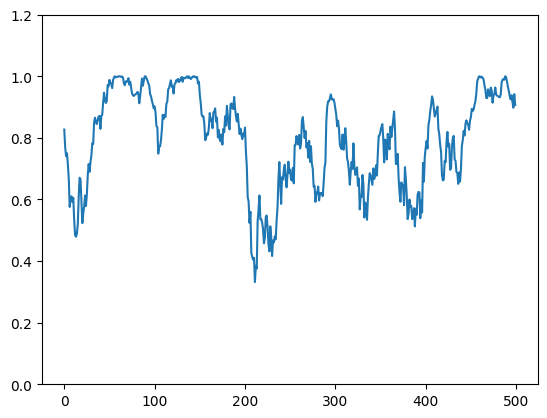

In [8]:
obs = env.reset(noise_scale=1)
# action = agent.choose_action(obs.reshape(1,-1))
# action = np.append(0,0)
# print(action)
plt.plot(obs)
plt.ylim(0,1.2)
plt.show()
# action = np.array([0,0])
# obs_,reward,done,_ = env.step(action)
# plt.plot(obs_)
# plt.ylim(0,1.2)
# plt.show(), np.sum(obs)/500

In [9]:
%%time
agent.choose_action(obs.reshape(1,-1,1))# +4.75

CPU times: user 144 ms, sys: 62.1 ms, total: 207 ms
Wall time: 237 ms


array([ 3.1809134, -2.239764 ], dtype=float32)

In [ ]:
log={}
score_hist = []
best_score = -np.inf
noise_scale = 1#env.noise_scale
print('Noise scale: ', noise_scale)
step = 0
for game in range(config['n_games']):
  done = False
  score = 0
  obs = env.reset(noise_scale=noise_scale)
  t=0
  while not done:
    action = agent.choose_action(obs.reshape(1,-1,1))
    mod_action = action#np.append(0,action)
    for l in range(len(mod_action)):
        log['voltage_'+str(l+1)] = np.pi*(mod_action[l]+1)
    obs_, reward, done,noise = env.step(1.1*(mod_action+1))
    log['reward'] = reward
    score += reward
    if env.terminal() == True:
      done_ = True
    else:
      done_ = False
    agent.remember(obs.reshape(-1,1), action, reward, obs_.reshape(-1,1), done_)
    if agent.mem_ready():
      log['actor_loss'], log['critic_loss'], log['ent_loss'], log['ent_coef'] = agent.learn()
    obs = obs_
    t+=1
    # wandb.log(log)
    # print(log)
  score_hist.append(score)
  avg_score = np.mean(score_hist[-100:])
  if avg_score > best_score:
    print('... saving ...')
    agent.save_models()
    best_score = avg_score
  if game%10 == 0 :#and
    env.eval = True
    print('Eval: ',eval_agent(agent, env, 0)[0])
    print('Eval: ',eval_agent(agent, env, 0.5)[0])
    print('Eval: ',eval_agent(agent, env, 1)[0])
    env.eval=False

  if game%50 ==0:
    noise_scale = min(1,noise_scale+0.1)
    print('Noise scale: %0.1f'%noise_scale)

  # if game%100==0 and game>1:
  #   agent.memory.delete_first_n(50*env.eps_length)

  print('episode ', game, 'score %.1f' % score,
          'average score %.1f' % avg_score, 'best score %0.1f'%best_score, 'steps ', t, 'done: ', done_)

Noise scale:  1
... saving ...
... saving checkpoint ...
eval score:  659.1339470204226
Eval:  False
eval score:  140.1819303319061
Eval:  False
eval score:  738.3754135400076
Eval:  False
Noise scale: 1.0
episode  0 score 253.3 average score 253.3 best score 253.3 steps  501 done:  True
... saving ...
... saving checkpoint ...
episode  1 score 276.7 average score 265.0 best score 265.0 steps  501 done:  True
episode  2 score 252.7 average score 260.9 best score 265.0 steps  501 done:  True
episode  3 score 251.4 average score 258.5 best score 265.0 steps  501 done:  True


In [ ]:
agent.load_models()

In [ ]:
env = CBC_Env(obs_dim=config['obs_dim'],n_actions=config['n_actions'],action_scale=config['max_action'],noise_scale=1,eps_length=1000, bias_point=0, v_pi=v_pi, eval=True)

In [ ]:
r2 = np.array([])
a2 = np.array([])
for _ in range(20):
  eval,r_hist, act_hist = eval_agent(agent, env, 1,rate=1,no_op=False)
  r2 = np.append(r2,r_hist)
  a2 = np.append(a2,act_hist)
print(eval)
plt.plot(r2.ravel())
plt.axhline(np.mean(r2.ravel()), linestyle='dashed', linewidth=2, color='k', label='mean: {_m}'.format(_m = np.round(np.mean(r2.ravel()),2)))
plt.ylim(0,1.2)
plt.legend()
plt.xlabel('Steps',fontsize=12)
plt.ylabel('Norm. Intensity', fontsize=12)
plt.grid()
plt.show()

plt.plot(np.pi*a2.ravel())
plt.xlabel('Steps',fontsize=14)
plt.ylabel('PZT Voltage',fontsize=14)
plt.grid()
plt.show()

In [ ]:
plt.plot(np.pi*a2.ravel())
plt.xlabel('Steps',fontsize=14)
plt.ylabel('PZT Voltage',fontsize=14)
plt.grid()
plt.show()
# plt.ylim(0,2.4)

In [ ]:
# agent.actor.eval()
%%time
actor = T.jit.load('./tmp/sac/actor_{_i}_channel_jit_v12.pt'.format(_i=config['n_actions']))
env = CBC_Env(obs_dim=config['obs_dim'],n_actions=config['n_actions'],action_scale=config['max_action'],noise_scale=1,eps_length=100000, bias_point=0, v_pi=v_pi, eval=True)

# for par in agent.actor.parameters():
#   par.requires_grad = False # freeze actor
done = False
score = 0
obs = env.reset(noise_scale=1)
r_hist = []
t_step = 0
act_hist=[]
while not done:
  s = T.tensor(obs.reshape(1,-1),dtype=T.float).to('cuda:0')
  if t_step%1==0:
    action = 1.1*T.tanh(actor.forward(s)[0]).cpu().detach().numpy()[0]#+1.1
  act_hist.append(action)
  # agent.choose_action(obs.reshape(1,-1),True)
  mod_action = np.append(0,action)
  obs_, reward, done,_ = env.step(mod_action)
  r_hist.append(reward)
  obs = obs_
  t_step+=1
# print('eval score: ', score)
# for par in agent.actor.parameters():
#   par.requires_grad = True # unfreeze actor
# agent.actor.train()
plt.plot(r_hist)
# plt.ylim(0,1.2)
plt.axhline(np.mean(r_hist),label='mean: {_m}'.format(_m = np.round(np.mean(r_hist),2)),color='k',linestyle='dashed',linewidth=2)
plt.legend()

plt.show()
plt.plot(act_hist,label='action')
plt.show()
np.sum(r_hist)

In [ ]:
0.25*np.pi/1.1

In [ ]:
import torch as T
actor = T.jit.trace(agent.actor, T.randn(1,500).to('cuda:0'))
T.jit.save(actor, './tmp/sac/actor_{_i}_channel_jit_v12.pt'.format(_i=config['n_actions']))

In [ ]:
actor = T.jit.load('./tmp/sac/actor_{_i}_channel_jit_v12.pt'.format(_i=config['n_actions']))

In [ ]:
%%timeit
s = T.rand(1,500).to('cuda:0')
T.tanh(actor.forward(s)[0])

In [ ]:
plt.plot(env.noise[:,1])